In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# torch
import torch
import pytorch_lightning as pl
from torch.utils.data import random_split

#vision
from torchvision.transforms import v2 as T

# utils
import numpy as np
from copy import copy
import json

# custom utils
from datasets.dataset import *
from helper_utils.plot_losses import *
from helper_utils.display import plot_sample
from models.smp_model import CatSegModel, save_model

### Data prep
Define transforms for the data:

In [3]:
# Example transformations
# @TODO: 1. load pre-procesing from model 2. what is the corect image size
data_transforms = {}
data_transforms['train'] = T.Compose([
    T.RandomResizedCrop(size=640, scale=(0.5, 1)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToImage(),
    #T.ToDtype(torch.float32, scale=True)
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_transforms['valid'] = T.Compose([
    T.Resize(670),
    T.CenterCrop(640),
    T.ToImage(),
    #T.ToDtype(torch.float32, scale=True)
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_transforms['test'] = data_transforms['valid']

Build dataset:

In [4]:
# get files
root = "H:\Cataract Dataset\FSR Dataset\Yolo_Segmentation_640x640"
full_dataset = SegmentationDataset(root)

# specify sizes
train_ratio = 0.7 # from total count
valid_ratio = 0.15 # from total count

# build datasets
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
valid_size = int(valid_ratio * total_size)
test_size = total_size - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])
train_dataset.dataset = copy(full_dataset) # disgusting solution for pytorch

# apply transforms
train_dataset.dataset.transform = data_transforms['train']
valid_dataset.dataset.transform = data_transforms['valid']
test_dataset.dataset.transform = data_transforms['test']


Plot a few images for example:

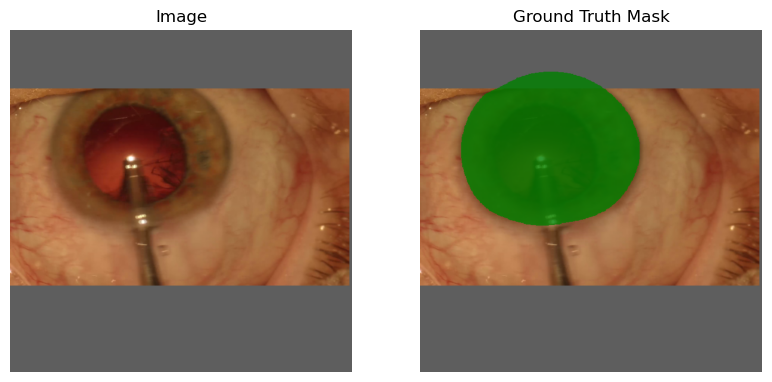

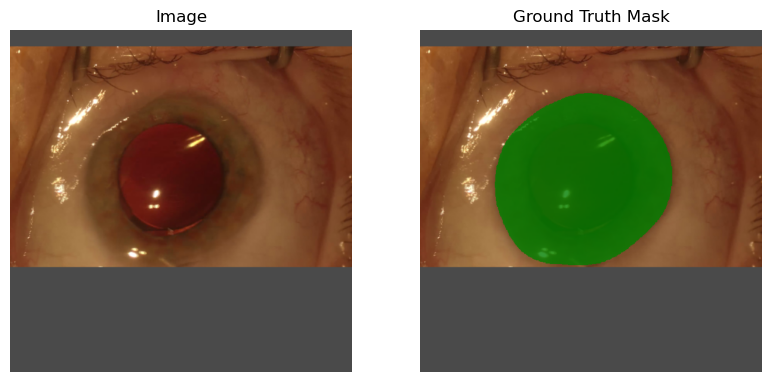

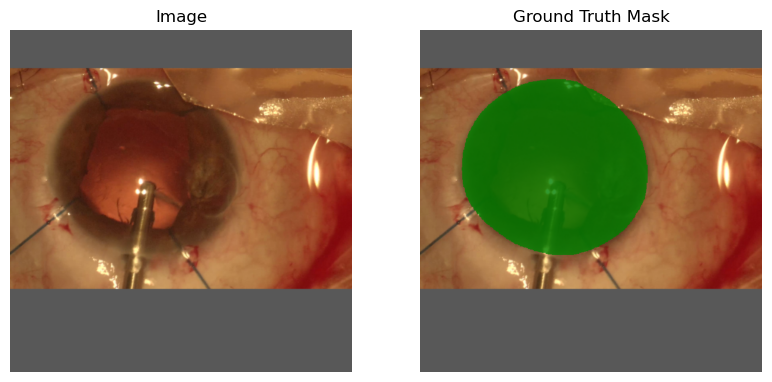

In [5]:
for _ in range(3):
    index = np.random.randint(0, len(test_dataset) - 1)
    plot_sample(train_dataset, index)

In [6]:
# Generate files split
train_dl, valid_dl, test_dl =  build_dataloaders(train_dataset, valid_dataset, test_dataset)

Todos:
- add pre-processing per data loader
- add metrics

## Build model
Config load:

In [7]:
config_path = 'configs/Unet_resnet34_train.json'
with open(config_path) as f:
    config = json.load(f)
print(json.dumps(config, indent=1))

{
 "NAME": "Unet_resnet34_pretrained_DiceLoss",
 "MODE": "train",
 "NUM_EPOCHS": 10,
 "CLASSES": [
  "pupil"
 ],
 "IN_CH": 3,
 "ARCH": "Unet",
 "ENCODER": "resnet34",
 "ENCODER_WEIGHTS": "imagenet",
 "LOSS": "DiceLoss",
 "LR": 0.001,
 "AUX_PARAMS": {
  "dropout": 0.5
 }
}


Build custom model using SMP library and the configuration file:

# Debug only

subset_size = len(train_dataset) // 10
indices = np.random.choice(len(train_dataset), subset_size, replace=False)
train_subset = torch.utils.data.Subset(train_dataset, indices)

subset_size = len(valid_dataset) // 10
indices = np.random.choice(len(valid_dataset), subset_size, replace=False)
valid_subset = torch.utils.data.Subset(valid_dataset, indices)

train_dl = DataLoader(train_subset, batch_size=6, shuffle=True)
valid_dl = DataLoader(valid_subset, batch_size=6, shuffle=True)


In [8]:
# setup
os.environ['TORCH_HOME'] = 'models/torch'
torch.set_float32_matmul_precision('high')

# build model
model = CatSegModel(config)

trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=config.get('NUM_EPOCHS',10),
    enable_progress_bar=True
)

trainer.fit(
    model, 
    train_dataloaders=train_dl, 
    val_dataloaders=valid_dl,
)

NameError: name 'torch' is not defined

In [ ]:
torch.save(model.state_dict(), 'models/models_cache/entire_model.pth')

In [ ]:
save_model(model)

1776

In [ ]:
trainer._logger_connector.logged_metrics

{'valid_per_image_iou': tensor(0.9445),
 'valid_dataset_iou': tensor(0.9409),
 'train_per_image_iou': tensor(0.9289),
 'train_dataset_iou': tensor(0.9233)}

In [ ]:
train_losses = model.train_outputs
valid_losses = model.valid_loss_log

import matplotlib.pyplot as plt

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()


AttributeError: 'CatSegModel' object has no attribute 'valid_loss_log'

Todo:
models transformation - maybe lightning has somethig? - load transforms from smp
save only the best models
logging issue with pl - switch to tensorboard
infer on test images using lightning ifeer
static idx numbers
save training reuslts
save using lightning chkpoint

separate evaluation script:
for all experiments
evaluation script
meeasure time

In [ ]:
import segmentation_models_pytorch as smp
f = smp.encoders.get_preprocessing_fn('efficientnet-b3')
ff = smp.encoders.get_preprocessing_params('efficientnet-b3')

smp.encoders.get

In [ ]:
ff

{'input_space': 'RGB',
 'input_range': [0, 1],
 'mean': [0.485, 0.456, 0.406],
 'std': [0.229, 0.224, 0.225]}